# Chapter 14: Surrogate Models

In [1]:
import numpy as np
from itertools import product
from dataclasses import dataclass
import matplotlib.pyplot as plt

## Algorithm 14.1

In [54]:
def design_matrix(X):
    n, m = len(X[0]), len(X)
    return np.array([ [1.0 if j == 0 else X[i][j-1] for j in range(n+1)]for i in range(m)])

def linear_regression(X,y):
    theta = np.linalg.solve(design_matrix(X),y)
    f = lambda x: np.matmul(theta,np.array([1]+x))
    return f

### Example

In [55]:
X = [[2,3,4],[3,2,4],[3,4,1],[3,4,3]]
y = [3,2,1,6]
model = linear_regression(X,y)
model([2,3,4])

3.0

## Algorithm 14.2

In [95]:
def regression(X, y, bases):
    B =[ b(x) for x, b in product(X, bases) ]
    theta = np.linalg.solve(B, y)
    f = lambda x: np.sum([theta[i]*bases[i](x) for i in range(len(theta))])
    return f

## Algorithm 14.3

In [57]:
def polynomial_bases_1d(i,k):
    f = lambda x: np.power(x[i],np.arange(0,k+1,1))
    return f

def polynomial_bases(n,k):
    bases = [ polynomial_bases_1d(i, k) for i in range(n)]
    terms = []
    for ks in product(*[np.arange(0,k+1) for i in range(n)]):
        if np.sum(ks) <= k:
            def func(x, ks=ks):
                return np.prod([b(x)[j] for j, b in zip(ks,bases) ])
            terms.append(func)

    return terms

### Example

In [58]:
# Test to compare Julia implementation
models = polynomial_bases(3,3)
sum_bases = 0
for model in models:
    sum_bases += model([2,3,4])
print(sum_bases)

350


## Algorithm 14.4

In [59]:
def sinusoidal_bases_1d(j, k, a, b):
    T= b[j] - a[j]
    def func(x,j,T,i):
        return np.sin(2*np.pi*i*x[j]/T)
    funcv = np.vectorize(func,excluded=[0,1,2])
    def func2(x,j,T,i):
        return np.cos(2*np.pi*i*x[j]/T)
    funcv2 = np.vectorize(func2,excluded=[0,1,2])

    def func_cat(x,j=j,T=T,i=np.arange(1, k+1)):
        return np.concatenate((funcv(x,j,T,i),funcv2(x,j,T,i)))

    return func_cat

def sinusoidal_bases(k, a, b):
    n = len(a)
    bases = [ sinusoidal_bases_1d(i, k, a, b) for i in range(n)]
    terms = []
    for ks in product(*[list(np.arange(0,(2*k))) for i in range(n)]):
        powers = [(k+1)//2 for k in ks]
        if np.sum(powers) <= k:
            def func(x, ks=ks):
                return np.prod([b(x)[j] for j, b in zip(ks,bases)]) 
            terms.append(func)

    return terms

In [60]:
models = sinusoidal_bases(3,[-1,-1],[1,1])
sum_bases = 0
for model in models:
    sum_bases += model([2,3])
print(sum_bases)

2.0818995585504995e-15


## Algorithm 14.5

In [61]:
def radial_bases(psi, C, p=2):
    bases = []
    for c in C:
        def func(x,c=c):
            return psi(np.linalg.norm(x-c,p))
        bases.append(func)
    return bases

## Algorithm 14.6

In [97]:
def regression(X, y, bases, lamb):
    B = np.array([[b(x) for b in bases] for x in X])
    theta = np.linalg.solve(np.matmul(B.T,B) + np.diag(lamb*np.ones((len(bases),1))),np.matmul(B.T,y))
    return lambda x: np.sum([theta[i]*bases[i](x) for i in range(len(theta))])

### Example

In [63]:
np.random.seed(35912)
bases = polynomial_bases(2,3)
X = [[2,3,4],[4,3,5],[4,5,1]]
y = np.random.rand(len(X)).reshape(-1,1)
lmb=[0.3 for i in range(len(bases))]
model = regression(X,y,bases,lmb)
print(model([4,6,7]))

1.48380802839926


## Algorithm 14.7

In [2]:
@dataclass
class TrainTest:
    train: list
    test: list
    
def train_and_validate(X, y, tt, fit, metric):
    model = fit(X[tt.train], y[tt.train])
    return metric(model, X[tt.test], y[tt.test])

## Algorithm 14.8

In [65]:
def holdout_partition(m, h=None):
    if h==None:
        h = m // 2
    p = np.random.permutation(m)
    train = p[h:m]
    holdout = p[0:h]
    return TrainTest( list(train), list(holdout) )

## Algorithm 14.9

In [66]:
def random_subsampling(X, y, fit, metric, h=None, k_max=10):
    if h == None:
        h = len(X)//2
    m = len(X)
    return np.mean([train_and_validate(X, y, holdout_partition(m, h), fit, metric) for k in range(k_max)])

## Algorithm 14.10

In [67]:
def k_fold_cross_validation_sets(m, k):
    perm = np.random.permutation(m)
    sets = []
    for i in range(k):
        validate = perm[i:m:k]
        train = perm[np.setdiff1d(np.arange(i,m),np.arange(i,m,k))]
        sets.append(TrainTest(train, validate))
    return sets

def cross_validation_estimate(X, y, sets, fit, metric):
    return np.mean([train_and_validate(X, y, tt, fit, metric) for tt in sets])

## Example 14.2

In [117]:
np.random.seed(0)
f = lambda x:np.sin(2*x)*np.cos(10*x)

# ---- Data generated in Julia with seed 0 to resemble results from book ---- #
X = np.array([0.8236475079774124, 
0.9103565379264364, 
0.16456579813368521, 
0.17732884646626457, 
0.278880109331201, 
0.20347655804192266,
0.042301665932029664,
0.06826925550564478,
0.3618283907762174,
0.9732164043865108]).reshape(-1,1)
y =np.array([ -0.4410340396417118,
 -0.9956556536332956,
  0.015573949795123155,
  0.01132320974198503,
 -0.5313248333867803,
 -0.19588413875990168,
 -0.08367168413613427,
 -0.14247105758074852,
 -0.3606906314525021,
 -0.8647008769320896]).reshape(-1,1)

# ------------------------------------------- #


sets = k_fold_cross_validation_sets(X.shape[0],3)

def metric(f, X, y):
    m = X.shape[0]
    return np.sum([(f(X[i])-y[i])**2 for i in range(m)])/m

lambda_s = 10**np.linspace(-4,2,101, dtype=np.float64)
es = []
basis = lambda r: np.exp(-5*r**2)
for lambd in lambda_s:
    def fit(X,y,lambd=lambd):
        bases = radial_bases(basis,X)
        return regression(X, y, bases, lambd)
    es.append(cross_validation_estimate(X, y, sets, fit, metric))

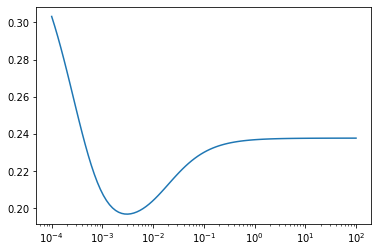

In [118]:
plt.semilogx(lambda_s,es)

## Algorithm 14.11

In [3]:
def bootstrap_sets(m, b):
    return [TrainTest(np.random.randint(0,m,size=m),np.arange(0,m)) for i in range(b)]

## Algorithm 14.12

In [ ]:
def bootstrap_estimate(X, y, sets, fit, metric):
    return np.mean([train_and_validate(X, y, tt, fit, metric) for tt in sets])

## Algorithm 14.13

In [ ]:
def leave_one_out_bootstrap_estimate(X, y, sets, fit, metric):
    m, b = len(X), len(sets)
    epsilon = 0.0
    models = [fit(X[tt.train], y[tt.train]) for tt in sets]
    for j in range(m):
        c = 0
        delta = 0.0
        for i in range(b):
            if j not in sets[i].train:
                c += 1
                delta += metric(models[i], np.array([X[j]]), np.array([y[j]]) )
        epsilon += delta/c
    
    return epsilon/m

## Algorithm 14.14

In [ ]:
def bootstrap_632_esimate(X, y, sets, fit, metric):
    models = [fit(X[tt.train], y[tt.train]) for tt in sets]
    epsilon_loob = leave_one_out_bootstrap_estimate(X, y, sets, fit, metric)
    epsilon_boot = bootstrap_estimate(X, y, sets, fit, metric)
    return 0.632*epsilon_loob + 0.368*epsilon_boot